# 06. Transfer Learning

Now, we take the parameters of what one model has learned on another dataset and applying it to our problem!

In [23]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


Let's import code from previous sections!

In [24]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

We need our pizza, steak and sushi :-)

In [26]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path}, let's download...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

  os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [27]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Let's turn the data into DataLoaders!

We can use our `data_setup.py` and `create_dataloaders()` function.

We must consider one thing... How to **transform** data? There are 2 ways:
1. Manually created transforms.
2. Automatically created transforms.

Important point: with a pretrained mode, it's important that the data we pass though is **transformed** in the same way that the data the model was trained on!

### 2.1 Creating a Transform for `torchvision.models` (Manual Creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`. All pre-trained models expect same normalization for images which we do now.

In [28]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

In [29]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cbc5c290490>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a Transform for `torchvision.models` (Auto Creation)

There is now support for automatic data transform creation based on the pretrained model weights we're using.

In [30]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [31]:
# Get the transforms used to get these weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [32]:
# Create DataLoaders using automatic transforms
train_dataloader_auto, test_dataloader_auto, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                         test_dir=test_dir,
                                                                                         transform=auto_transforms,
                                                                                         batch_size=32)
train_dataloader_auto, test_dataloader_auto, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cbc5be88fd0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a Pretrained Model

There are various places ot get pretrained models from:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of diffferent models)
4. Paperswithcode (for models across different probelm  spaces / domains)

### 3.1 Which Pretrained Model to Use?

*Experiment, experiment, experiment!*

Take a well-performing model from a similar problem-space to your own and then customize it.

Three things to consider:
1. How fast it runs?
2. How big is the model?
3. How well does the model go on my problem?

Where does the model live?

Is it on device (like a self-driving car)?

Or does it live on a server?

So, which model should we choose?
(https://docs.pytorch.org/vision/main/models.html)

It seems like EffNetB0 is one of the best options considering performance vs size...

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.


### 3.2 Setting Up a Pretrained Model

In [33]:
# OLD method (prior torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method :)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a Summary of Our Model with `torchinfo.summary`

In [34]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the Base Model and Changing the Output Layer

With a feature extractor model, we usually "freeze" the vase layers of the model and update at least the output layers to suit our problem.

In [35]:
for param in model.features.parameters():
  param.requires_grad = False

In [36]:
# Updating the classifier head
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [37]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train Model

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 8.715 seconds


## 5. Evaluate Model by Visualizing

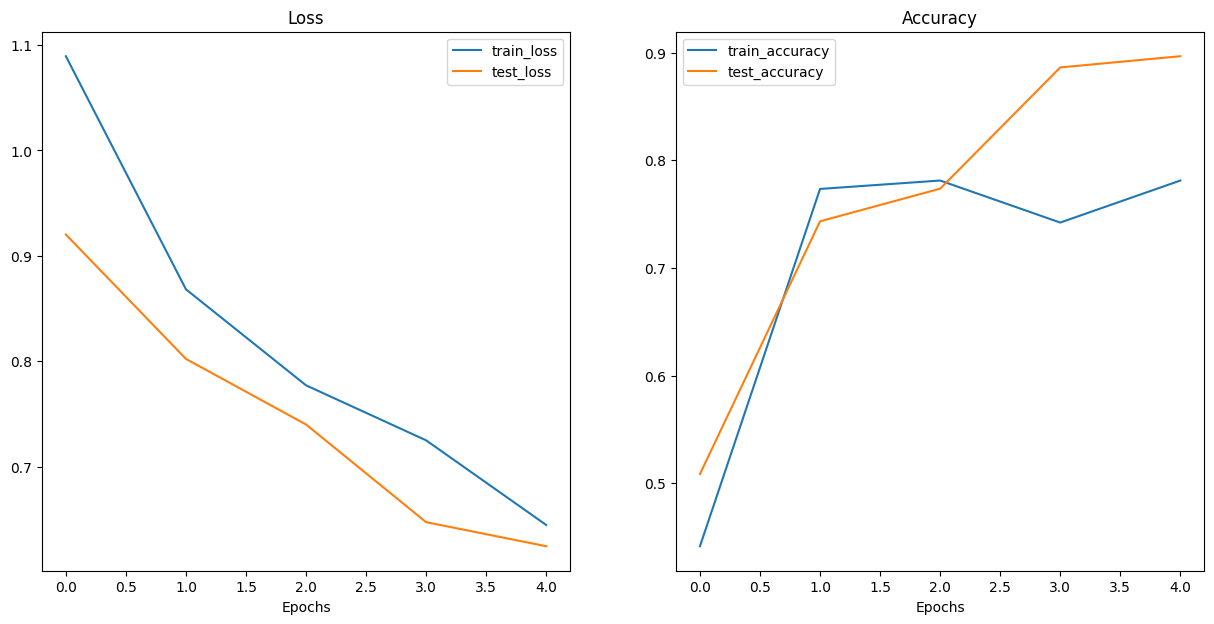

In [40]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    print("Downloading...")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 6. Make Predictions on Images from the Test Set

Remember, the test/custom data needs to be:
* Same shape as the data the model was trained on
* Same datatype
* Same device
* Same transform

Let's functionize this!

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Make a transform if one does not exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` to ensure it is ready for inference
6. Transform the target image and make sure its' dimensionality is suited for the model
7. Make a prediction on the image with a forward pass
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert the prediction probabilities to prediction labels with `torch.argmax()
10. Plot the image with `matpoltlib` and set the title to the prediction label from step 9 and the prediction probabilities

In [45]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  """
  Make a prediction on a target image with a trained model and plot the image with the prediction
  """
  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch size, C, H, W]
    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);


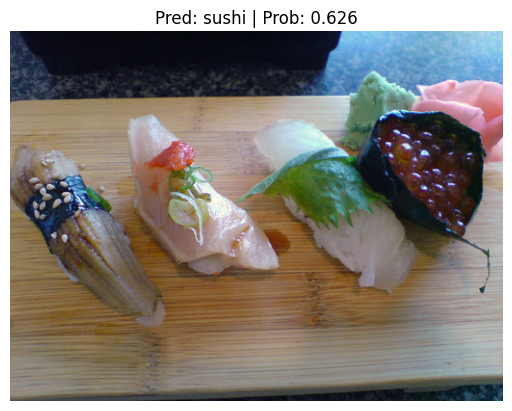

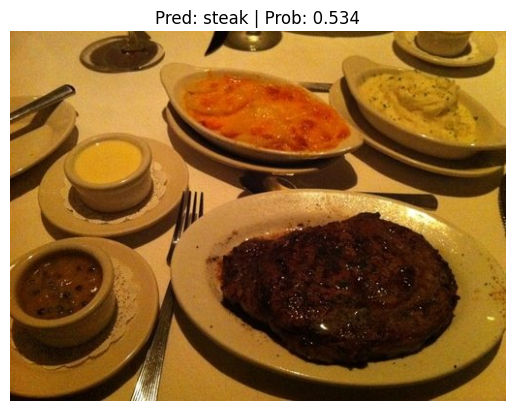

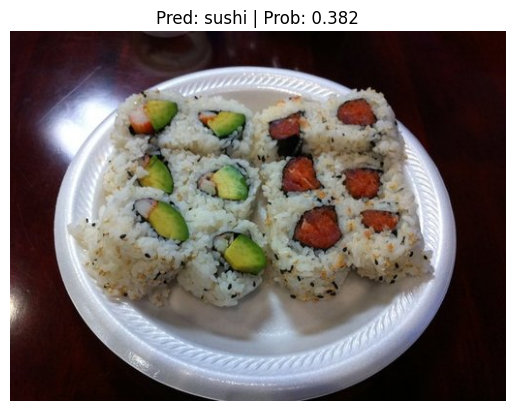

In [46]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### 6.1 Making Predictions on a Custom Image

In [52]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists!")

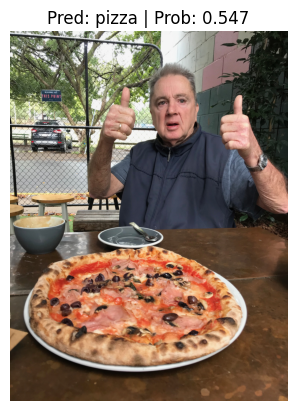

In [53]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)